# Análise estatística dos dados do IBGE

No presente trabalho, faremos uma análise bem específica do Dataset do PNAD do IBGE 2010, buscando responder uma pergunta de negócio. Este trabalho foi proposto como desafio no primeiro módulo do curso de Data Science da Digital House e, abaixo, apresento a solução desenvolvida por mim.

## Objetivo &mdash; A pergunta de negócio:

A pergunta escolhida, a qual será respondida ao final da análise, foi:

**"As regiões do Brasil apresentam escolaridades médias (estatisticamente) diferentes?"**

In [97]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

## EDA 

In [98]:
# Lendo e visualizando o dataset:

df = pd.read_csv(r'./data/demografia.csv')
display(df.head())
df.tail()

,seq,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte
1,1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte
2,2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte


,seq,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
66465,66465,5.311702e+10,34,mulher,5.0,Branca,NaN,1.0,centro-oeste
66466,66466,5.311702e+10,40,homem,5.0,Parda,2425.000000,1.0,centro-oeste
66467,66467,5.311702e+10,36,mulher,5.0,Parda,2425.000000,1.0,centro-oeste
66468,66468,5.311702e+10,27,mulher,5.0,Branca,5524.200195,1.0,centro-oeste
66469,66469,5.311702e+10,37,homem,5.0,Preta,460.350006,1.0,centro-oeste


In [102]:
# Como nosso objetivo é comparar apenas duas colunas do dataset, anos_estudo e regiao, vamos desconsiderar as demais:
df = df[['seq', 'anos_estudo', 'regiao']]
df.head()

,seq,anos_estudo,regiao
0,0,5.0,norte
1,1,8.0,norte
2,2,11.0,nordeste
3,3,15.0,norte
4,4,15.0,norte


In [100]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
seq,66470,NaN,NaN,NaN,33234.5,19188.4,0,16617.2,33234.5,49851.8,66469
anos_estudo,66036,NaN,NaN,NaN,8.68607,3.37452,5,5,8,11,15
regiao,66470,5,sudeste,25220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explorando anos_estudo:

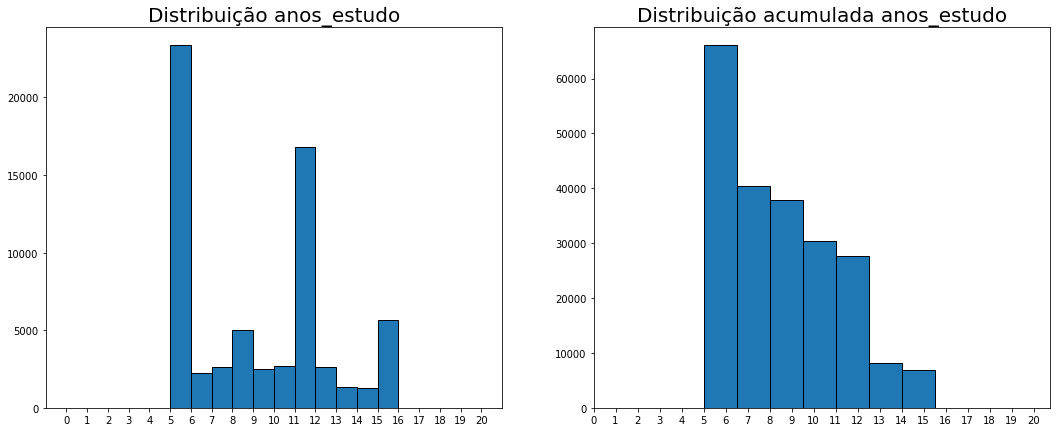

5.0     23349
11.0    16790
15.0     5636
8.0      5017
10.0     2704
7.0      2612
12.0     2610
9.0      2474
6.0      2237
13.0     1348
14.0     1259
Name: anos_estudo, dtype: int64

In [111]:
# Visualizando a distribuição:

fig, ax = plt.subplots(1,2, figsize=(18,7))

ax[0].hist(df.anos_estudo.dropna(), bins = 20, range= (0,20), ec='black')
ax[0].set_xticks(range(0,21))
ax[0].set_title('Distribuição anos_estudo', fontsize='20')

ax[1].hist(df.anos_estudo.dropna(), cumulative=-1, bins = 10, range = (5,20), ec='black')
ax[1].set_xticks(range(0,21))
ax[1].set_title('Distribuição acumulada anos_estudo', fontsize='20')

plt.show()
display(df.anos_estudo.value_counts(dropna=False))

&rarr; Aqui vale um comentário mais detalhado. Alguns pontos a serem observados:

1) Ocorrência de (poucos) valores nulos;

2) A ocorrência dos picos no primeiro histograma deve-se aos ciclos de ensino no Brasil. 5 anos corresponde ao Ensino Fundamental I completo, 8 anos corresponde ao Ensino Fundamental II completo, 11 anos de estudo correspondem ao Ensino Médio completo e 14 e 15 anos de estudo correspondem ao Ensino Superior Completo

3) Em um país como o Brasil, em que 7% da população ainda é analfabeta (PNAD 2017), parece estranho que, em uma amostra com 66000 observações, nenhum indivíduo tenha menos do que 5 anos de estudo. Da mesma forma, parece estranho que nenhum indivíduo tenha mais do que 15 anos de estudo. Isso indica um viés em potencial na pesquisa.



In [103]:
# Nulos:

perc = df['anos_estudo'].isnull().sum()/df.shape[0] * 100
print('Os valores nulos correspondem a apenas {:.2f}% dos valores da coluna \'anos_estudo\'.'.format(perc))

Os valores nulos correspondem a apenas 0.65% dos valores da coluna 'anos_estudo'.


In [104]:
# Como os valores nulos correspondem a uma fração muito pequena do Dataset,
# vamos optar por desconsiderá-los uma vez que não é possível inferir a que se referem.
df.dropna(subset=['anos_estudo'], inplace=True)

* ## Analisando e tratando 'região'

In [13]:
df.regiao.value_counts()

sudeste         25220
centro-oeste    14702
norte           14653
sul             11890
nordeste            5
Name: regiao, dtype: int64

- #### Podemos notar a presença de um viés nesse conjunto de dados, uma vez que a região nordeste apresenta apenas 5 indivíduos. Assim, por ser uma quantidade pouco significativa, optaremos por excluir a referida região dessa análise.

In [14]:
# Passando a máscara para remoção dos valores da região nordeste:
df_teste = df['regiao'][(df['regiao'] != 'nordeste')]
df_teste.value_counts()

sudeste         25220
centro-oeste    14702
norte           14653
sul             11890
Name: regiao, dtype: int64

In [15]:
#Sobrescrevendo o DataFrame original:
df['regiao'] = df_teste
df.regiao.value_counts()

sudeste         25220
centro-oeste    14702
norte           14653
sul             11890
Name: regiao, dtype: int64

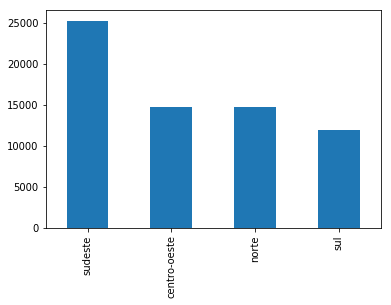

In [16]:
df.regiao.value_counts().plot(kind ='bar')

* ## Cruzando as variáveis 'região' e 'anos_estudo':

In [17]:
df_cross = pd.DataFrame(df.groupby('regiao')['anos_estudo'].mean())
df_cross

,anos_estudo
regiao,
centro-oeste,8.645646
norte,8.312951
sudeste,8.902115
sul,8.736788


In [18]:
# E se eu quisesse usar um laço para nomear as variaveis? Seria possível atrelar o nome de uma variável à variável temporária do laço?

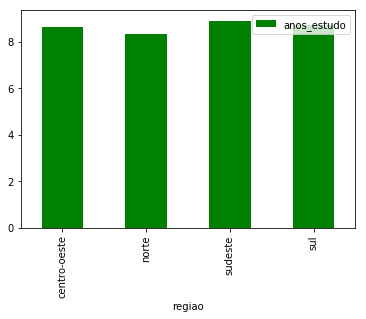

In [19]:
df_cross.plot(kind = 'bar',color = 'green')

* ##  Análise Estatística:

In [20]:
# Definindo funções de amostragem:
def sampling(df, n):
    index = np.random.choice(range(0, len(df)), size = n)
    df_s = np.array(df.iloc[index,])
    return (df_s)

def samp_means(df, n_i, n_reps):
    means = []
    for reps in range(n_reps):
        s_ = sampling(df, n_i)
        m_ = s_.mean()
        means.append(m_)
    return (means)

In [21]:
# Criando uma distribuição normal das médias de anos de estudo:

df_estudo = pd.DataFrame(df['anos_estudo'])
df_estudo.dropna(0, inplace = True)
n = 1000
sample = samp_means(df_estudo, n, 1000)

In [22]:
# Rodando o teste t para comparar as médias de cada região com a média da pop.
# Hipótese nula: as médias das regiões são estatisticamente iguais à média total da população.
for i in range(0,4):
    teste_t = st.ttest_1samp(sample, df_cross.anos_estudo[i])
    if teste_t[1] < 0.05:
        analise = 'Rejeitamos a hipótese nula.'
    else :
        analise = 'Não rejeitamos a hipótese nula.'
    print ('Regiao {0:}: \n>>> p-valor = {1:} \n>>> Resultado: {2}'.format(df_cross.index[i], teste_t[1], analise))

Regiao centro-oeste: 
>>> p-valor = 5.746078684597263e-34 
>>> Resultado: Rejeitamos a hipótese nula.
Regiao norte: 
>>> p-valor = 0.0 
>>> Resultado: Rejeitamos a hipótese nula.
Regiao sudeste: 
>>> p-valor = 0.0 
>>> Resultado: Rejeitamos a hipótese nula.
Regiao sul: 
>>> p-valor = 4.216860923253391e-41 
>>> Resultado: Rejeitamos a hipótese nula.


In [25]:
# Definindo intervalo de confiança e testando a hipótese nula para a média de cada região:
mean, sigma = np.mean(sample), np.std(sample)
SE = sigma/np.sqrt(n)
intervalo = st.norm.interval(alpha = 0.95, loc = mean, scale = SE)

for i in range(0,4):
    print (intervalo[0], '<---->', intervalo[1])
    if intervalo[0] < df_cross.anos_estudo[i] < intervalo [1]:
        
        print ('Região: {0:}\n>>> Resultado: Não rejeitamos a nula'.format(df_cross.index[i]))
    else:
        print('Região: {0:}\n>>> Resultado: Rejeitamos a nula'.format(df_cross.index[i]))

8.682057796456265 <----> 8.695444203543735
Região: centro-oeste
>>> Resultado: Rejeitamos a nula
8.682057796456265 <----> 8.695444203543735
Região: norte
>>> Resultado: Rejeitamos a nula
8.682057796456265 <----> 8.695444203543735
Região: sudeste
>>> Resultado: Rejeitamos a nula
8.682057796456265 <----> 8.695444203543735
Região: sul
>>> Resultado: Rejeitamos a nula


In [52]:
# Calculando t, t crítico e testando se rejeitamos a nula para t:
t_critico_inferior = st.ttest_1samp(sample, intervalo[1])[0]
t_critico_superior = st.ttest_1samp(sample, intervalo[0])[0]
for i in range(0,4):
    t_ = st.ttest_1samp(sample, df_cross.anos_estudo[i])[0]
    if t_critico_inferior < t_ < t_critico_superior:
        print ('Região: {0:}\n>>> Resultado: Não rejeitamos a nula'.format(df_cross.index[i]))
    else:
         print('Região: {0:}\n>>> Resultado: Rejeitamos a nula'.format(df_cross.index[i]))

Região: centro-oeste
>>> Resultado: Rejeitamos a nula
Região: norte
>>> Resultado: Rejeitamos a nula
Região: sudeste
>>> Resultado: Rejeitamos a nula
Região: sul
>>> Resultado: Rejeitamos a nula


# **Resposta final:** de fato, a região interfere sim na média de anos de estudo da população. Ou seja, a média de anos de estudo de cada região é significativamente diferente.